# LSTM Model

The LSTM model in this system is designed to forecast sensor readings of two sensors: R1 and R2. Using time series data from the sensors, the model forecasts the sensors' resistor values in kΩ to display how the air quality will change over time throughout the day of residential household. Model performance is evaluated using metrics such as MSE, RMSE, R², and the predicted vs actual curve for both R1 and R2 sensors.


### Environment Set Up

In [1]:
!git clone https://github.com/aladenisun/MSAAI_530_FinalProject

Cloning into 'MSAAI_530_FinalProject'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 86 (delta 29), reused 49 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (86/86), 1.85 MiB | 18.61 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q -r /content/MSAAI_530_FinalProject/requirements.txt

In [4]:
import sys
import os

def in_colab():
    return "COLAB_GPU" in os.environ or "google.colab" in sys.modules

if in_colab():
    # running in Google Colab
    repo_path = "/content/MSAAI_530_FinalProject"
    data_path = "/content/MSAAI_530_FinalProject/data"

    # set working directory to the repo root
    os.chdir(repo_path)

else:
    # running locally in VS Code
    repo_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
    data_path = os.path.abspath(os.path.join(repo_path, "data"))

    # add repo root to Python path
    if repo_path not in sys.path:
        sys.path.append(repo_path)

    # set working directory to the repo root
    os.chdir(repo_path)

print("Using repo path:", repo_path)
print("Using data path:", data_path)
print("CWD:", os.getcwd())

Using repo path: /content/MSAAI_530_FinalProject
Using data path: /content/MSAAI_530_FinalProject/data
CWD: /content/MSAAI_530_FinalProject


In [5]:
# import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import os

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from keras.utils import pad_sequences
from sklearn.metrics import mean_squared_error, r2_score

### Create Train, Validation, and Test Datasets

We trained the model on a segment of our data and then measured its performance on simulated streaming data another segment of the data. Using a chronological 80/20 spilt for the training and validation sets. The test split will come from the training data as part of the tensorflow LSTM model call.

In [6]:
dataset_csv = os.path.join(data_path, "Cleaned_HT_Sensor_Dataset.csv")

# load CSVs
df = pd.read_csv(dataset_csv, delimiter=",").dropna()

# focus only on the first two MOX gas sensors
feature_cols = ["R1", "R2"]
target_cols = ["R1", "R2"]

# create a copy of the dataframe
df_model = df[feature_cols].copy()

# chronological 80/20 split
split_idx = int(np.floor(0.8 * len(df_model)))

train_df = df_model.iloc[:split_idx].reset_index(drop=True)
val_df   = df_model.iloc[split_idx:].reset_index(drop=True)

print("Original head:\n", train_df.head())

print("Train data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

Original head:
         R1       R2
0  12.8621  10.3683
1  12.8617  10.3682
2  12.8607  10.3686
3  12.8602  10.3686
4  12.8595  10.3688
Train data shape: (10252, 2)
Validation data shape: (2563, 2)


### Create supervised sequences for forecasting

We created supervised sequences to allow the LSTM to learn the relationship between past sensor behavior and future readings. Time series data is inherently sequential, but neural networks require structured input target pairs during training. By using the previous 30 timesteps as input and predicting R1 and R2 senors five steps ahead, we teach the model to recognize temporal patterns and understand how current air quality trends evolve into future conditions.

We chose the previous 30 timesteps to give the LSTM enough historical context to learn meaningful temporal patterns in the sensor data. MOX gas sensors respond gradually to environmental changes, so short windows may miss important trends, while excessively long windows can introduce noise and increase overfitting. A 30 step window provides a balanced amount of recent history to capture rising or falling air quality patterns without making the model unnecessarily complex.

A predictive horizon of 5 steps was selected to forecast slightly ahead of the immediate next reading. Predicting multiple steps into the future encourages the model to learn underlying dynamics rather than simply copying the most recent value. This makes the forecasting task more realistic for near real-time monitoring and strengthens anomaly detection, since meaningful deviations between predicted and actual values become more apparent over a short future interval rather than just one timestep ahead.

In [7]:
seq_length = 30   # use last 30 timesteps to predict next step
horizon = 5     # predict next 5 steps ahead

target_idx = [feature_cols.index(c) for c in target_cols]

def create_sequences(data, seq_length, horizon, target_idx):
    """
    data: np.array shape (T, num_features)
    returns:
      X: (N, seq_length, num_features)
      y: (N, len(target_idx)) predicting next step targets
    """
    X, y = [], []
    T = len(data)
    for i in range(seq_length, T - horizon + 1):
        X.append(data[i - seq_length:i, :])
        y.append(data[i + horizon - 1, target_idx])
    return np.array(X, dtype = np.float32), np.array(y, dtype = np.float32)

seq_arrays, seq_labs = create_sequences(train_df.values, seq_length, horizon, target_idx)

print("X_train:", seq_arrays.shape, "y_train:", seq_labs.shape)

X_train: (10218, 30, 2) y_train: (10218, 2)


### Build LSTM Forecast Model

This LSTM architecture was intentionally designed to be lightweight while still capturing the temporal dynamics of the sensor data. The two stacked LSTM layers (16 and 8 units) allow the model to learn short-term and slightly longer-term patterns in air quality behavior without introducing excessive complexity. Because the dataset is moderate in size and the forecasting task involves only two continuous outputs (R1 and R2), a smaller architecture is sufficient to model the underlying trends. Reducing the number of hidden units lowers the number of trainable parameters, decreases computational cost, and improves generalization by limiting the risk of overfitting.

The Dense layer with a ReLU activation is used to introduce nonlinearity after temporal features are extracted by the LSTM layers. ReLU is computationally efficient, helps prevent vanishing gradient issues, and enables the model to represent nonlinear relationships in the sensor dynamics without adding significant overhead. The final layer remains linear because the task is regression, and mean squared error (MSE) is appropriate for continuous forecasting. Early stopping and adaptive learning rate scheduling further improve stability and prevent unnecessary training.

Overall, this architecture aligns well with the IoT system's goal of being lightweight and efficient, particularly for cloud deployment, where it can provide near real-time forecasting with minimal computational burden.

In [10]:
# define path to save model
model_path = "LSTM_model.keras"

# build the network
n_features = seq_arrays.shape[-1]
nb_out = len(target_cols)

model = Sequential([
    Input(shape=(seq_length, n_features)),
    LSTM(16, return_sequences=True),
    Dropout(0.2),
    LSTM(8),
    Dense(8, activation="relu"),
    Dense(nb_out)
])

# set optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

# callbacks (early stopping + adaptive learning rate)
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=4,                 # stop earlier to prevent overfitting
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=model_path,
        monitor="val_loss",
        save_best_only=True
    )
]

history = model.fit(
    seq_arrays, seq_labs,
    validation_split=0.05,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# list all data in history
print(history.history.keys())

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 104.0353 - val_loss: 23.4986 - learning_rate: 0.0010
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 22.4958 - val_loss: 0.6100 - learning_rate: 0.0010
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 3.1156 - val_loss: 0.5692 - learning_rate: 0.0010
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 1.3581 - val_loss: 1.0873 - learning_rate: 0.0010
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.2119 - val_loss: 1.2066 - learning_rate: 0.0010
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.1891 - val_loss: 0.6604 - learning_rate: 0.0010
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.4840 - val_loss: 0.3528 - learning_rate: 5.0000e-04
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.2667 - val_loss: 0.3304 - learning_rate: 5.0000e-04
Epoch 9/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.1931 - val_loss: 0.3211 - learning_ra

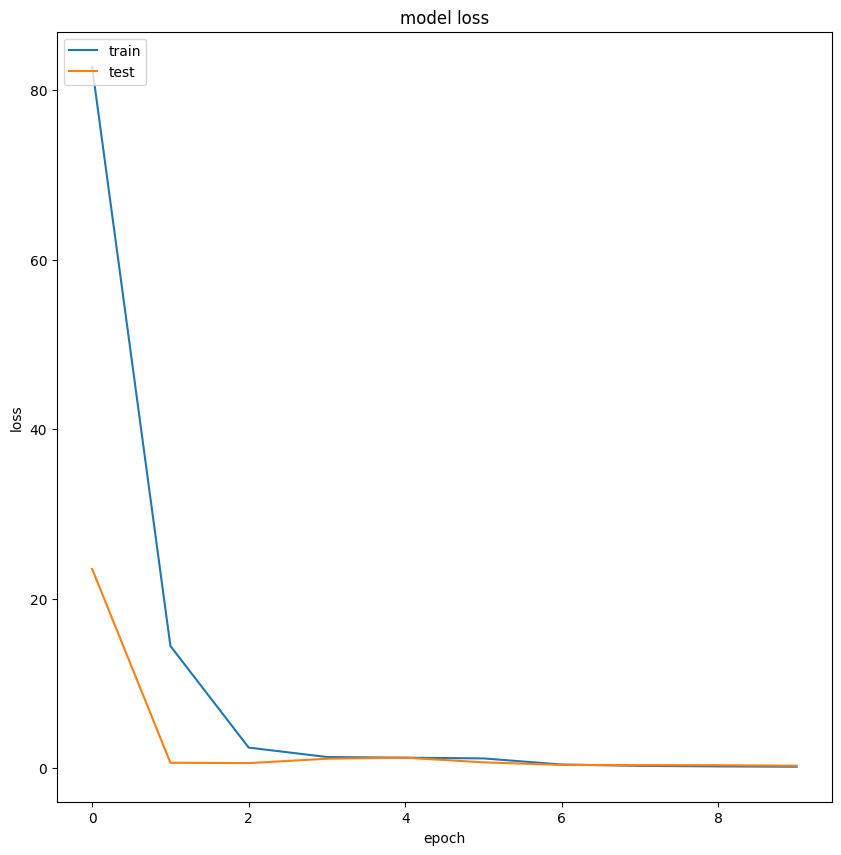

In [11]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(("model loss"))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The plot shows both training and validation loss decreasing rapidly during the first few epochs, indicating that the model is learning the underlying patterns quickly. The training loss starts high, drops sharply by the second epoch, and then gradually stabilizes at a very low value. The validation loss follows a similar trend, closely tracking the training curve without diverging. After approximately epoch 4–6, both curves flatten and remain stable, suggesting that the model has converged and is not exhibiting significant overfitting. The small and consistent gap between training and validation loss indicates good generalization performance.

### Validating Our Model
To validate our model with the validation data we need to structure it in a way that mimics how the LSTM model would operate in a real deployment, while ensuring compatibility with the model's fixed input requirements. The LSTM was trained to accept inputs of shape (seq_length, number_of_features), meaning every prediction requires a sequence of exactly 30 past timesteps. However, when generating predictions sequentially, especially at the beginning of a validation period, there may not yet be 30 available readings. To address this, the code first builds rolling history windows using whatever past data is available. Starting once at least two readings exist and then applies padding so that every sequence matches the required fixed length.

Padding is critical because neural networks like LSTMs, require consistent input dimensions. Without padding, early validation samples would be shorter than 30 timesteps and could not be passed into the model. By using pre-padding, adding values to the beginning of the sequence, we preserve the most recent and most relevant sensor readings at the end of each sequence while filling any missing data earlier history. This allows the model to make predictions immediately, maintains consistency with how the training sequences were structured, and ensures stable, realistic evaluation without altering the learned temporal relationships.

In [12]:
val_arrays = []
val_labs   = []

# Start predictions once 2 readings are available
# i is the "cutoff" index for input history: we use data up to i-1, predict at i+horizon-1
for i in range(2, len(val_df) - horizon + 1):
    # rolling history window (up to seq_length most recent samples)
    start = max(0, i - seq_length)
    seq = val_df[feature_cols].iloc[start:i].values.tolist()   # shape (<=seq_length, 2)
    val_arrays.append(seq)

    # label matches create_sequences(): index i + horizon - 1
    y = val_df[target_cols].iloc[i + horizon - 1].values.tolist()
    val_labs.append(y)

# Pad to fixed length (N, seq_length, 2)
val_arrays = pad_sequences(
    val_arrays,
    maxlen=seq_length,
    dtype="float32",
    padding="pre",
    truncating="pre"
)

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=np.float32)

print("val_arrays:", val_arrays.shape)
print("val_labs:  ", val_labs.shape)

val_arrays: (2557, 30, 2)
val_labs:   (2557, 2)


### Run Validation Data

80/80 - 1s - 7ms/step - loss: 0.1948

Overall MSE: 0.19482572376728058


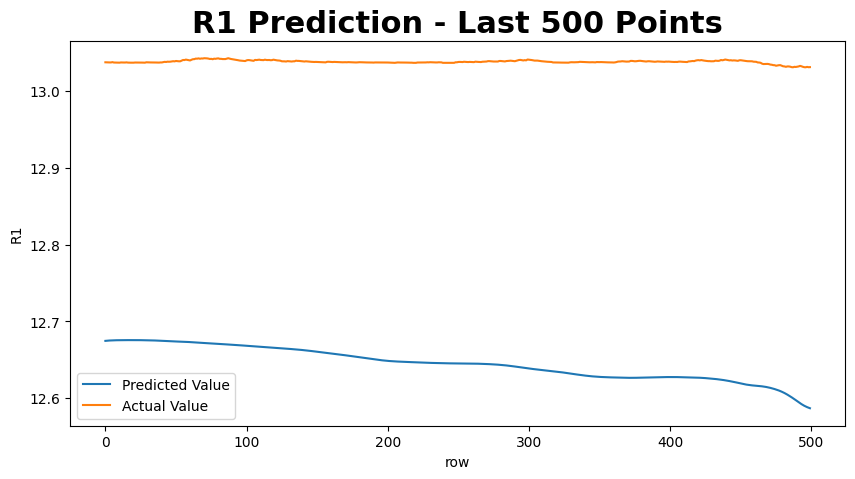

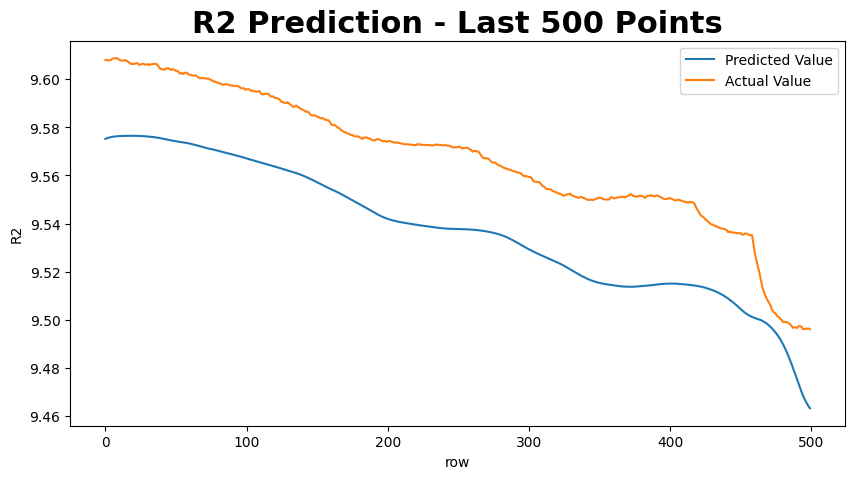

In [18]:
mse_test = model.evaluate(val_arrays, val_labs, verbose=2)
print(f"\nOverall MSE: {mse_test}")

y_pred_test = model.predict(val_arrays, verbose=0)
y_true_test = val_labs

# Plot predicted vs actual for the last 500 points
n_plot = min(500, len(y_pred_test))

for j, col in enumerate(target_cols):
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test[-n_plot:, j], label="Predicted Value")
    plt.plot(y_true_test[-n_plot:, j], label="Actual Value")
    plt.title(f"{col} Prediction - Last {n_plot} Points", fontsize=22, fontweight="bold")
    plt.ylabel(col)
    plt.xlabel("row")
    plt.legend()
    plt.show()
    fig_verify.savefig(f"model_regression_verify_{col}.png", dpi=300, bbox_inches="tight")

The overall mean squared error (MSE) of 0.1948 indicates that, on average, the squared difference between the predicted and actual sensor readings is relatively small in magnitude. However, when interpreted alongside the prediction plots, it becomes clear that the model exhibits a consistent bias rather than random fluctuation error. In the R1 plot, the predicted values remain systematically lower than the actual readings across the entire segment. While both curves follow a generally smooth trend, the model does not fully capture the absolute level of the signal, resulting in a noticeable vertical offset between predicted and actual values.

A similar behavior is observed for the R2 sensor, where predictions track the general trend but show a persistent deviation from the true readings. The model captures the temporal pattern reasonably well, indicating it has learned the directional behavior of the sensor dynamics. However, the bias suggests that the model underestimates the magnitude of the readings. Therefore, while the MSE value reflects moderate prediction error, the visual comparison shows that the issue is not instability or noise but rather a steady offset between predicted and actual values.

### Evaluate Metrics

In [17]:
# Compute MSR, RMSE, and R² per sensor
for j, col in enumerate(target_cols):
    mse = mean_squared_error(y_true_test[:, j], y_pred_test[:, j])
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_test[:, j], y_pred_test[:, j])

    print(f"\n{col} Metrics:")
    print(f"MSE:  {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R²:   {r2:.6f}")


R1 Metrics:
MSE:  0.367451
RMSE: 0.606177
R²:   -4.841980

R2 Metrics:
MSE:  0.022201
RMSE: 0.148999
R²:   0.909475


For R1, the MSE of 0.367 and RMSE of 0.606 indicate a relatively large prediction error compared to the signal's variation. More importantly, the R² value of -4.84 is strongly negative, which means the model performs significantly worse than a simple baseline that predicts the mean of the R1 data. This suggests that while the model may capture some general trend behavior, it is failing to accurately model the magnitude of R1 values, likely due to systematic bias or underestimation observed in the prediction plots.

In contrast, R2 shows strong performance. The MSE of 0.022 and RMSE of 0.149 are relatively small, indicating low average prediction error. The R² value of 0.91 means that the model explains approximately 91% of the variance in R2 readings, which reflects a very good fit. Overall, the model performs well for R2 but struggles significantly with R1.

### Create Tableau DataFrame

To build our dashboard components, we must align the R1 and R2 prediction values with the original dataset so that all actual and forecasted data can be accurately visualized and summarized.

In [29]:
# Create dataframe for predictions
test_set = pd.DataFrame(y_pred_test, columns=target_cols)
test_set.columns = ["R1_pred", "R2_pred"]

# Select the last 2577 rows from the original dataframe to match test_set
tableau_df = df.tail(2577).reset_index(drop=True)

# If prediction set is slightly shorter (due to seq_length & horizon),
# align by trimming the beginning of tableau_df
if len(test_set) < len(tableau_df):
    tableau_df = tableau_df.iloc[-len(test_set):].reset_index(drop=True)

# Concatenate predictions alongside original data
tableau_df = pd.concat([tableau_df, test_set], axis=1)

print(tableau_df)

tableau_df.to_csv("tableau_dashboard_data.csv", index=False)

      id      time       R1       R2       R3        R4       R5       R6  \
0      0  1.916919  12.2543  7.97727  7.89595   8.95149  22.7337  13.9941   
1      0  1.917197  12.2537  7.97680  7.89606   8.95136  22.7293  13.9938   
2      0  1.917475  12.2536  7.97667  7.89671   8.95125  22.7253  13.9936   
3      0  1.917753  12.2529  7.97641  7.89717   8.95115  22.7199  13.9934   
4      0  1.918042  12.2523  7.97617  7.89744   8.95091  22.7145  13.9933   
...   ..       ...      ...      ...      ...       ...      ...      ...   
2552   0  2.633601  13.0313  9.49602  9.56483  10.71550  12.4730  14.0551   
2553   0  2.633879  13.0312  9.49625  9.56518  10.71550  12.4721  14.0552   
2554   0  2.634172  13.0317  9.49630  9.56567  10.71510  12.4714  14.0552   
2555   0  2.634450  13.0313  9.49633  9.56628  10.71530  12.4707  14.0549   
2556   0  2.634728  13.0314  9.49603  9.56666  10.71550  12.4703  14.0549   

           R7       R8     Temp  Humidity    R1_pred   R2_pred  
0     6.20